# Seq2Seq Machine Translation (99% accuracy)

### Seq2Seq or sequence-to-sequence mdoel is a ML achitecture designed for tasks involving sequential data.It takes an input sequence processes it and generates an output sequence.
 >It consists of two main components: Encoder and Decoder.
 >It is widely udes in NLP tasks due to its ability to handle variable length input and output sequences

### we will use teacher forcing during training to increase the accuracy of the model:-
> Plugging in the known word and stopping at the known length instead of using predictive output for everything is know as teacher forcing.

> We will offset it by sos token so that our model dont learn to just copy the output.

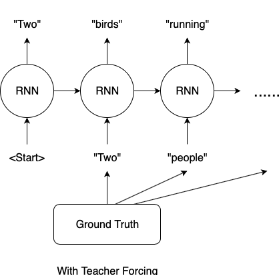
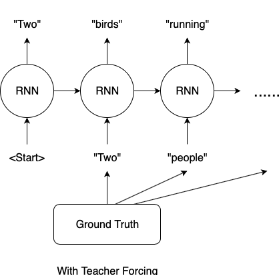

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.utils import shuffle
%matplotlib inline 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Bidirectional,Activation,Lambda,Input,Embedding,LSTM

## 1. Getting the data

In [2]:
df=pd.read_csv('/kaggle/input/hindi-english-parallel-corpus/hindi_english_parallel.csv')
print(df.head())

                                               hindi  \
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें   
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक   
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका   
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका   
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...   

                                          english  
0  Give your application an accessibility workout  
1               Accerciser Accessibility Explorer  
2  The default plugin layout for the bottom panel  
3     The default plugin layout for the top panel  
4  A list of plugins that are disabled by default  


## 2. EDA and Cleaning

In [3]:
print(len(df))

1561841


In [4]:
# Checking for Null values
df.isnull().sum() 

hindi      6057
english     877
dtype: int64

In [5]:
# Dropping null values and resetting the index
df.dropna(inplace=True)
df=df.reset_index(drop=True)

In [6]:
df.isnull().sum()

hindi      0
english    0
dtype: int64

In [7]:
len(df)

1555574

In [8]:
df['english']

0             Give your application an accessibility workout
1                          Accerciser Accessibility Explorer
2             The default plugin layout for the bottom panel
3                The default plugin layout for the top panel
4             A list of plugins that are disabled by default
                                 ...                        
1555569                  शपथ लेने/प्रतिज्ञान करने वाले सदस्य
1555570    स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
1555571    है। I note that this is a landmark meeting – n...
1555572    है। In the presentations that they made before...
1555573    ्त है। Issues such as food and water security;...
Name: english, Length: 1555574, dtype: object

In [9]:
# There are some rows in english columns that contains hindi
df.iloc[1555570]

hindi      स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
english    स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
Name: 1555570, dtype: object

In [10]:
# Removing the rows that contains hindi sentences as it will just create noise in the dataset
def contains_Hindi(text):
    if isinstance(text,str):
        return bool(re.search(r'[\u0900-\u097F]',text))
    return False
df_filtered=df[~df['english'].apply(contains_Hindi)].reset_index(drop=True)

## 3. Preprocessing the Data

In [11]:
Embedding_dim=100
Latent_dim=400
max_seq_len=100
max_vocab_size=20000

In [12]:
# As the data size is large we will work with 20000 sentences
input_text=[]
target_text=[]
target_text_input=[]
translation=[]
i=19999
for j,t in enumerate(df['english']):
    input_text.append(t)
    if j==i:
        j=0
        break
for j,t in enumerate(df['hindi']):
    translation.append(t)
    target_text.append(t+' <eos>')
    target_text_input.append('<sos> '+t)
    if j==i:
        break

### we will create different tokenizer for input and output as both contains different vocabulary

In [13]:
#Input
tokenizer_input=Tokenizer(num_words=max_vocab_size)
tokenizer_input.fit_on_texts(input_text)
tokenized_input=tokenizer_input.texts_to_sequences(input_text)

In [14]:
word2idx=tokenizer_input.word_index
print('word2idx length:',len(word2idx))

word2idx length: 2036


In [15]:
#Output
tokenizer_output=Tokenizer(num_words=max_vocab_size,filters='')
tokenizer_output.fit_on_texts(target_text_input+target_text)
tokenized_target=tokenizer_output.texts_to_sequences(target_text)              #target output
tokenized_target_input=tokenizer_output.texts_to_sequences(target_text_input)  #teacher forcing 

In [16]:
word2idx_output=tokenizer_output.word_index
print('length of word2idx output:',len(word2idx_output))
num_words_output=len(word2idx_output)+1

length of word2idx output: 2936


In [17]:
#Input
encoder_input=pad_sequences(tokenized_input,maxlen=max_seq_len)
print('Encoder input shape=',encoder_input.shape)

Encoder input shape= (20000, 100)


In [18]:
#target output as input for teacher forcing
decoder_input=pad_sequences(tokenized_target_input,maxlen=max_seq_len,padding='post')
print('decoder input shape:',decoder_input.shape)

decoder input shape: (20000, 100)


In [19]:
#target output
decoder_output=pad_sequences(tokenized_target,maxlen=max_seq_len,padding='post')
print('decoder output shape:',decoder_output.shape)

decoder output shape: (20000, 100)


### We will use Global Vector (GloVe) for representing the word vectors of english words

In [20]:
word_vec={}
with open("/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.%sd.txt" % Embedding_dim,encoding='utf-8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vector=np.asarray(values[1:],dtype='float32')
        word_vec[word]=vector
print('length of word vector=',len(word_vec))

length of word vector= 400000


In [21]:
#creating count matrix
num_words=min(max_vocab_size,len(word2idx)+1)
word_embedding=np.zeros((num_words,Embedding_dim))
for word,i in word2idx.items():
    if i<max_vocab_size:
        vec=word_vec.get(word)
        if vec is not None:
            word_embedding[i]=vec
print('shape of word_embedding:',word_embedding.shape)

shape of word_embedding: (2037, 100)


In [22]:
embedding_layer_input=Embedding(num_words,
                          Embedding_dim,
                          weights=[word_embedding],
                          trainable=False)

## 4. Defining Model Architecture

>During training we will use teacher foring so will pass the entire target sequence as input and during prediction we will only one token as input.
>
>But As Keras works with constant-sized inputs we will create two different models for decoder.

In [23]:
#Encoder
encoder_input_placeholder=Input(shape=(max_seq_len,))
x=embedding_layer_input(encoder_input_placeholder)
encoder_lstm=LSTM(Latent_dim,return_state=True)
encoder_output,h,c=encoder_lstm(x)
encoder_states=[h,c]

In [24]:
#Decoder
decoder_input_placeholder=Input(shape=(max_seq_len,))
decoder_embedding=Embedding(num_words_output,Embedding_dim)
x=decoder_embedding(decoder_input_placeholder)
decoder_lstm=LSTM(Latent_dim,return_state=True,return_sequences=True)
decoder_outputs,_,_=decoder_lstm(x,initial_state=encoder_states)
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [25]:
model=Model([encoder_input_placeholder,decoder_input_placeholder],      # Teacher Forcing
            decoder_outputs)

In [26]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [27]:
hist=model.fit([encoder_input,decoder_input],
               decoder_output,
               epochs=10,
               validation_split=0.2,
               batch_size=64)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.9336 - loss: 1.0505 - val_accuracy: 0.9677 - val_loss: 0.2201
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9641 - loss: 0.2308 - val_accuracy: 0.9685 - val_loss: 0.1959
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9675 - loss: 0.1945 - val_accuracy: 0.9708 - val_loss: 0.1666
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - accuracy: 0.9717 - loss: 0.1546 - val_accuracy: 0.9750 - val_loss: 0.1291
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9766 - loss: 0.1170 - val_accuracy: 0.9794 - val_loss: 0.0978
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9820 - loss: 0.0862 - val_accuracy: 0.9836 - val_loss: 0.0739
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9863 - loss: 0.0645 - val_accuracy: 0.9872 - val_loss: 0.0580
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.9893 - loss: 0.0504 - 

### Plotting the loss and Accuracy matrics

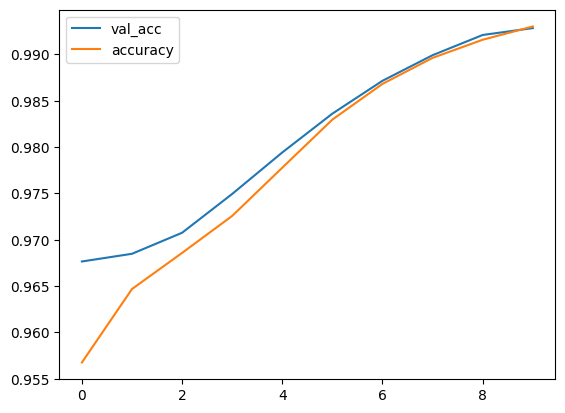

In [28]:
plt.plot(hist.history['val_accuracy'],label='val_acc')
plt.plot(hist.history['accuracy'],label='accuracy')
plt.legend()

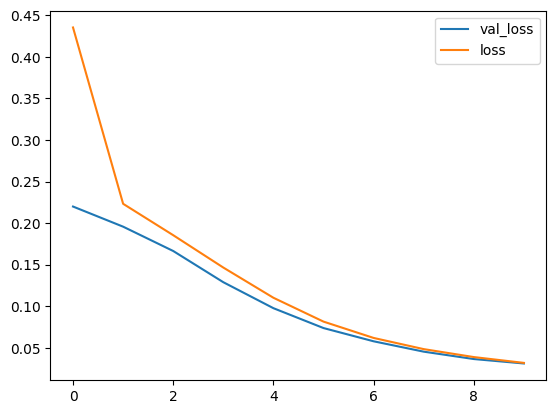

In [29]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

## 5. Creating the inference model

> The inital encoder model is the one we trained originally.We cant use the previos model as it was use for training.
>
> We will create another model instance which will be based on the same architecture we trained originally and will use the same layers we trained upon so that we can reuse the weights and biases we trained originally

In [30]:
encoder_model=Model(encoder_input_placeholder,encoder_states)

In [31]:
# Decoder for prediction (one input at a time)
decoder_inital_h=Input(shape=(Latent_dim,))
decoder_inital_c=Input(shape=(Latent_dim,))

decoder_initial_states=[decoder_inital_h,decoder_inital_c]

decoder_input_single=Input(shape=(1,))                            
decoder_embedding_single=decoder_embedding(decoder_input_single)
decoder_outputs_x,h,c=decoder_lstm(decoder_embedding_single,initial_state=decoder_initial_states)

decoder_states=[h,c]

decoder_output=decoder_dense(decoder_outputs_x)

decoder_model=Model([decoder_input_single]  +  decoder_initial_states,
                    [decoder_output]  +  decoder_states
                   )

In [32]:
idx2word_output={v:k for k,v in word2idx_output.items()}

In [33]:
def decode_sequence(sequence):
    states_value=encoder_model.predict(sequence,verbose=0)     # context vector:-will return [h,c]

    target_seq=np.zeros((1,1))
    target_seq[0,0]=word2idx_output['<sos>']    #First input to decoder

    eos=word2idx_output['<eos>']

    output_sequence=[]

    for _ in range(max_seq_len):
        output_token,h,c=decoder_model.predict([target_seq]+states_value,verbose=0)

        idx=np.argmax(output_token[0,0,:])
        
        if idx==eos:                       # if the predicted token is <eos>
            break

        if idx>0:
            output_sequence.append(idx2word_output[idx])

        target_seq[0,0]=idx

        states_value=[h,c]
    
    return ' '.join(output_sequence)

## 6. Model Evaluation

In [34]:
i=0
while i<4:
    j=np.random.choice(len(encoder_input))
    input_seq=encoder_input[j:j+1]
    seq=decode_sequence(input_seq)
    print('------------------')
    print('input text:',input_text[j])
    print('real output',translation[j])
    print('predicted output:',seq)
    i+=1

------------------
input text: Enable smart indentation
real output स्मार्ट हाशिया सक्रिय करें
predicted output: स्मार्ट हाशिया सक्रिय करें
------------------
input text: Languages:
real output भाषाएँः
predicted output: भाषाएँः
------------------
input text: Subversion operations
real output उर्ध्वाधर पैमाना
predicted output: सबवर्सन संचालन
------------------
input text: Diff Selected Revisions
real output डिफ चयनित
predicted output: डिफ चयनित
